# Iterative Deepening Hyperband Meets YAHPO-Gym's lcbench and nb301

This notebook contains the experimental evaluation of iterative deepening hyperband (ID-HB) using the YAHPO Gym benchmark.
In this notebook, we put a focus on benchmarks optimizing hyperparameters of a neural network and where the fidelity can be adjusted by means of the number of epochs the respective neural network is trained.

## Setup the Resources

First of all, we need to setup the MySQL database and specify the connection details in `config/database_credentials.cfg`. Initially, we also need to setup YAHPO and tell it where to find the data for its surrogate models.
Then, we set up the evaluation function for IDHB and the candidate sampler as follows. Furthermore, we setup a method named `run_experiment` which takes an experiment specification and evaluates it with the corresponding benchmark, instance, metric, Hyperband variant, and its parameterization. The `run_experiment` function will report the best candidate found, its performance according to the maximum budget, and how much budget was consumed during the optimization process in total.

In [2]:
from yahpo_gym import benchmark_set, local_config
import numpy as np
from idhb import *
import os
from py_experimenter.result_processor import ResultProcessor
from py_experimenter.experimenter import PyExperimenter
import time


local_config.init_config()
local_config.set_data_path("yahpodata")

class YAHPOEvaluationFunction:
    def __init__(self, bench, metric):
        self.bench = bench
        self.metric = metric

    def evaluate(self, candidate, budget):
        xs = candidate.get_dictionary()
        # print("evaluate candidate ", xs, " for budget " , budget)
        xs["epoch"] = int(budget)
        return (-1) * self.bench.objective_function(xs)[0][self.metric]


class YAHPOCandidateSampler:
    def __init__(self, cs, seed):
        self.bracket_random_state = dict()
        self.global_random_state = seed
        self.cs = cs

    def get(self, bracket, n):
        candidates = list()
        # draw a list of n candidates
        for i in range(n):
            # retrieve random state to set seed for sampling
            if bracket in self.bracket_random_state:
                random_state = self.bracket_random_state[bracket]
            else:
                np.random.seed(self.global_random_state)
                self.global_random_state = np.random.randint(0, 2 ** 16 - 1)
                random_state = np.random.randint(0, 2 ** 16 - 1)
            np.random.seed(random_state)
            random_state = np.random.randint(0, 2 ** 16 -1)
            self.bracket_random_state[bracket] = random_state
            
            self.cs.seed(seed=random_state)
            candidates.append(Candidate(candidate=self.cs.sample_configuration(1)))
        return candidates


def run_experiment(keyfields: dict, result_processor: ResultProcessor, custom_fields: dict):
    debug = False
    seed = int(keyfields['seed'])
    benchmark = keyfields['benchmark']
    instance = keyfields['instance']
    algo = keyfields['algo']
    metric = keyfields['metric']
    eta = int(keyfields['eta'])
    initial_max_budget = int(keyfields['init_max_budget'])

    bench = benchmark_set.BenchmarkSet(benchmark)
    bench.set_instance(instance)
    cs = bench.get_opt_space(drop_fidelity_params=True)
    eval = BudgetTrackingPerformanceMeasure(YAHPOEvaluationFunction(bench, metric).evaluate)

    sampler = YAHPOCandidateSampler(cs=cs, seed=seed)
    if algo == "pid-hb":
        hb = IDHyperband(max_budget=initial_max_budget, eta=eta, eval_func=eval.evaluate, conservative=True, strict=False, debug=debug)
    elif algo == "did-hb":
        hb = IDHyperband(max_budget=initial_max_budget, eta=eta, eval_func=eval.evaluate, conservative=True, strict=True, debug=debug)
    else:
        hb = IDHyperband(max_budget=initial_max_budget, eta=eta, eval_func=eval.evaluate, conservative=False, debug=debug)
    hb.hyperband(sampler)

    if algo == "ih-hb":
        sampler = YAHPOCandidateSampler(cs=cs, seed=seed)
        hb = IDHyperband(max_budget=initial_max_budget * eta, eta=eta, eval_func=eval.evaluate, conservative=False, debug=debug)
        res = hb.hyperband(sampler)
    elif algo == "eid-hb" or algo == "pid-hb" or algo == "did-hb":
        hb.incrementMaxBudget()
        res = hb.hyperband(sampler)
    else:
        print("Not supported algo!")

    results = {
        'final_incumbent': str(res.getCandidate()),
        'performance': (-1) * res.performanceMap[initial_max_budget * eta],
        'total_budget': eval.getAccumulatedBudget()
    }
    result_processor.process_results(results)


## Setup PyExperimenter
Setup the py_experimenter framework to allow easy management of experiments

In [3]:
experimenter = PyExperimenter(experiment_configuration_file_path="config/yahpo_nb301.cfg", database_credential_file_path="config/database_credentials.cfg")


## Fill Experiment Table
The following cell only needs to be executed to initialize the experiment table.

In [4]:
experimenter.fill_table_from_config()

## Execute Experiments

Run all the experiments specified in the database.

In [1]:
experimenter.execute(experiment_function=run_experiment, max_experiments=-1, random_order=True)

NameError: name 'experimenter' is not defined

# Results

In the following, we derive plots from the results obtained through the experiments above.

## Total Budget Consumed for (ID-)HB with $\eta=2$

Average budget consumption across various instances of the lcbench benchmark.

In [94]:
eid_hb= [1128.0, 1128.0, 1128.0, 1128.0, 1128.0, 1128.0, 1128.0, 1128.0, 1128.0, 1128.0, 1128.0, 1128.0, 1128.0, 1128.0, 1128.0, 1128.0, 1128.0, 1128.0, 1128.0, 1128.0, 1128.0, 1128.0, 1128.0, 1128.0, 1128.0, 1128.0, 1128.0, 1128.0, 1128.0, 1128.0, 1128.0, 1128.0, 1128.0, 1128.0]
did_hb= [1155.2, 1154.5333333333333, 1157.0666666666666, 1151.4666666666667, 1155.2666666666667, 1155.6, 1152.7333333333333, 1159.4, 1156.9333333333334, 1157.2, 1150.6666666666667, 1158.7333333333333, 1151.4666666666667, 1159.4666666666667, 1143.8666666666666, 1151.6, 1151.6, 1154.8275862068965, 1156.0666666666666, 1151.6, 1157.8666666666666, 1159.1333333333334, 1157.1333333333334, 1156.3333333333333, 1151.6666666666667, 1154.4, 1153.6, 1147.6666666666667, 1152.6666666666667, 1157.6, 1156.2, 1148.0, 1156.1333333333334, 1152.4666666666667]
pid_hb= [1147.1333333333334, 1150.5333333333333, 1153.5333333333333, 1149.9333333333334, 1147.8666666666666, 1152.4666666666667, 1154.2, 1151.1333333333334, 1153.3333333333333, 1153.2666666666667, 1149.4666666666667, 1144.8666666666666, 1142.9333333333334, 1154.4, 1145.4666666666667, 1151.7333333333333, 1149.7333333333333, 1152.5333333333333, 1151.3333333333333, 1149.8666666666666, 1149.8666666666666, 1149.0666666666666, 1149.8666666666666, 1150.8, 1150.1333333333334, 1144.2, 1152.0666666666666, 1150.9333333333334, 1149.0, 1147.8666666666666, 1151.6, 1147.4666666666667, 1151.0666666666666, 1152.4666666666667]
ih_hb= [1500.0, 1500.0, 1500.0, 1500.0, 1500.0, 1500.0, 1500.0, 1500.0, 1500.0, 1500.0, 1500.0, 1500.0, 1500.0, 1500.0, 1500.0, 1500.0, 1500.0, 1500.0, 1500.0, 1500.0, 1500.0, 1500.0, 1500.0, 1500.0, 1500.0, 1500.0, 1500.0, 1500.0, 1500.0, 1500.0, 1500.0, 1500.0, 1500.0, 1500.0]

eid_hb = np.array(eid_hb)
did_hb = np.array(did_hb)
pid_hb = np.array(pid_hb)
ih_hb = np.array(ih_hb)

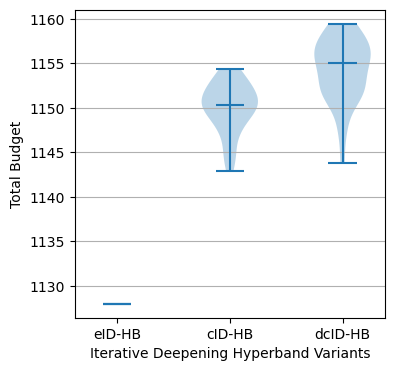

In [95]:
import matplotlib.pyplot as plt
import numpy as np

fig, ax = plt.subplots(nrows=1, figsize=(4, 4))

# generate some random test data
all_data = [eid_hb, pid_hb, did_hb]#, ih_hb]

# plot violin plot
ax.violinplot(all_data, showmeans=False, showmedians=True)

# adding horizontal grid lines
ax.yaxis.grid(True)
ax.set_xticks([y + 1 for y in range(len(all_data))],
                  labels=['eID-HB', 'cID-HB', 'dcID-HB'])#, 'IH-HB'])
ax.set_xlabel('Iterative Deepening Hyperband Variants')
ax.set_ylabel('Total Budget')
#plt.yscale('log')

plt.savefig('budget_distribution_yahpo_lcbench_2.pdf')
plt.show()

lcbench_2


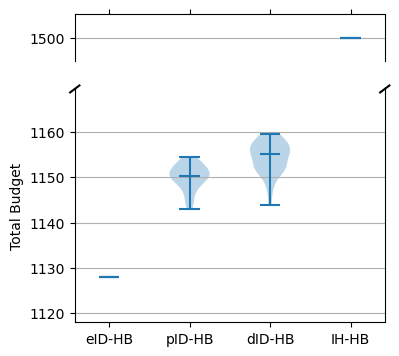

lcbench_3


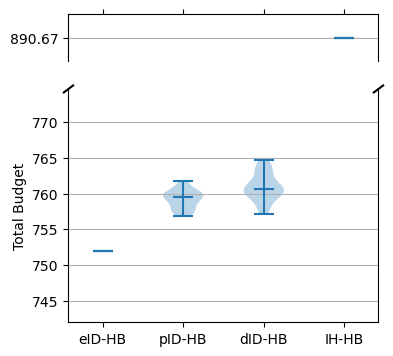

nb301_2


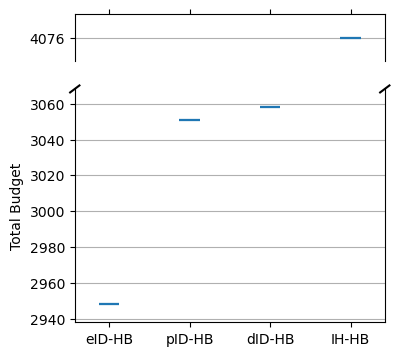

nb301_3


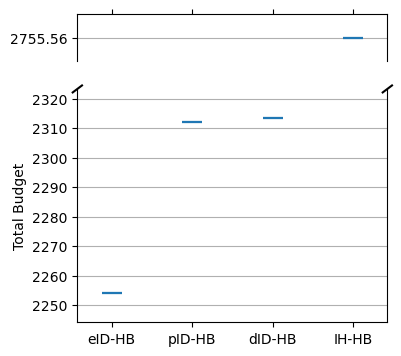

rbv2_ranger_2


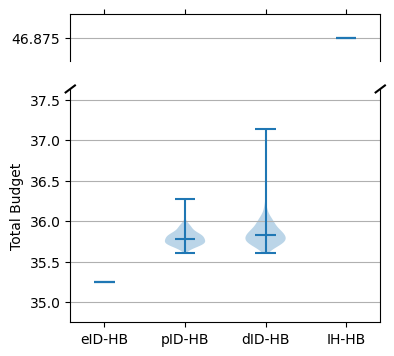

rbv2_ranger_3


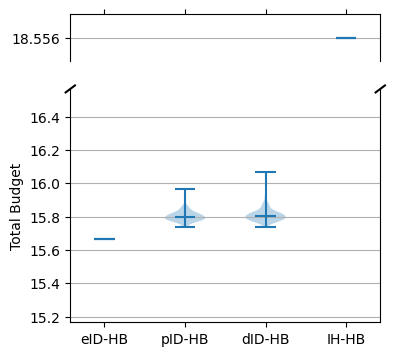

rbv2_svm_2


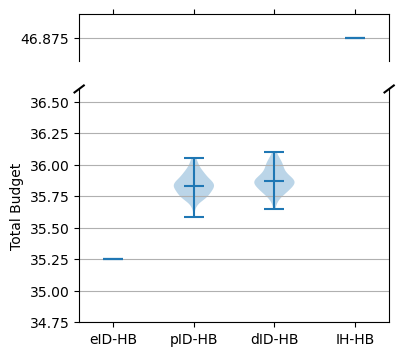

rbv2_svm_3


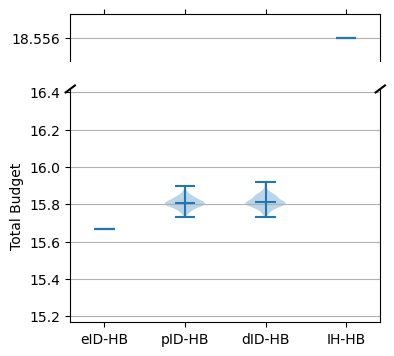

rbv2_xgboost_2


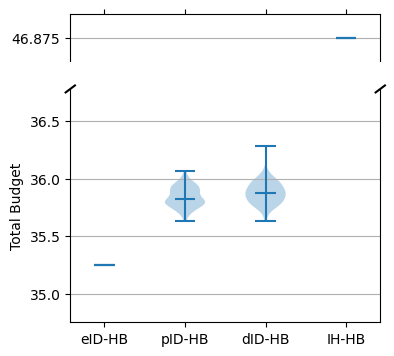

rbv2_xgboost_3


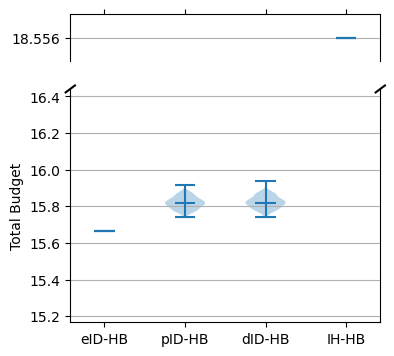

In [70]:
import matplotlib.pyplot as plt
import numpy as np

data = {
    "lcbench_2": {
    "did_hb": [1155.2, 1154.53, 1157.07, 1151.47, 1155.27, 1155.6, 1152.73, 1159.4, 1156.93, 1157.2, 1150.67, 1158.73, 1151.47, 1159.47, 1143.87, 1151.6, 1151.6, 1154.83, 1156.07, 1151.6, 1157.87, 1159.13, 1157.13, 1156.33, 1151.67, 1154.4, 1153.6, 1147.67, 1152.67, 1157.6, 1156.2, 1148.0, 1156.13, 1152.47],
    "pid_hb": [1147.13, 1150.53, 1153.53, 1149.93, 1147.87, 1152.47, 1154.2, 1151.13, 1153.33, 1153.27, 1149.47, 1144.87, 1142.93, 1154.4, 1145.47, 1151.73, 1149.73, 1152.53, 1151.33, 1149.87, 1149.87, 1149.07, 1149.87, 1150.8, 1150.13, 1144.2, 1152.07, 1150.93, 1149.0, 1147.87, 1151.6, 1147.47, 1151.07, 1152.47],
    "eid_hb": [1128.0, 1128.0, 1128.0, 1128.0, 1128.0, 1128.0, 1128.0, 1128.0, 1128.0, 1128.0, 1128.0, 1128.0, 1128.0, 1128.0, 1128.0, 1128.0, 1128.0, 1128.0, 1128.0, 1128.0, 1128.0, 1128.0, 1128.0, 1128.0, 1128.0, 1128.0, 1128.0, 1128.0, 1128.0, 1128.0, 1128.0, 1128.0, 1128.0, 1128.0],
    "ih_hb": [1500.0, 1500.0, 1500.0, 1500.0, 1500.0, 1500.0, 1500.0, 1500.0, 1500.0, 1500.0, 1500.0, 1500.0, 1500.0, 1500.0, 1500.0, 1500.0, 1500.0, 1500.0, 1500.0, 1500.0, 1500.0, 1500.0, 1500.0, 1500.0, 1500.0, 1500.0, 1500.0, 1500.0, 1500.0, 1500.0, 1500.0, 1500.0, 1500.0, 1500.0]
    },
    "lcbench_3": {
    "did_hb": [757.69, 760.18, 761.24, 761.07, 761.24, 759.47, 760.71, 758.04, 760.53, 757.16, 760.53, 760.71, 763.56, 760.18, 763.56, 764.27, 758.93, 760.53, 761.24, 760.0, 760.18, 759.47, 761.78, 759.82, 760.89, 763.2, 762.84, 757.69, 761.96, 763.91, 764.62, 759.64, 759.64, 762.84],
    "pid_hb": [759.47, 759.64, 758.58, 758.76, 760.18, 760.18, 757.69, 757.16, 759.64, 758.04, 759.82, 758.76, 761.6, 760.89, 759.64, 757.51, 759.64, 756.98, 757.87, 759.64, 758.93, 756.8, 761.07, 758.93, 760.36, 757.33, 760.18, 760.0, 757.69, 760.18, 758.4, 759.29, 761.78, 760.18],
    "eid_hb": [752.0, 752.0, 752.0, 752.0, 752.0, 752.0, 752.0, 752.0, 752.0, 752.0, 752.0, 752.0, 752.0, 752.0, 752.0, 752.0, 752.0, 752.0, 752.0, 752.0, 752.0, 752.0, 752.0, 752.0, 752.0, 752.0, 752.0, 752.0, 752.0, 752.0, 752.0, 752.0, 752.0, 752.0],
    "ih_hb": [890.67, 890.67, 890.67, 890.67, 890.67, 890.67, 890.67, 890.67, 890.67, 890.67, 890.67, 890.67, 890.67, 890.67, 890.67, 890.67, 890.67, 890.67, 890.67, 890.67, 890.67, 890.67, 890.67, 890.67, 890.67, 890.67, 890.67, 890.67, 890.67, 890.67, 890.67, 890.67, 890.67, 890.67]
    },
    "nb301_2": {
    "did_hb": [3058.27],
    "pid_hb": [3050.8],
    "eid_hb": [2948.0],
    "ih_hb": [4076.0]
    },
    "nb301_3": {
    "did_hb": [2313.24],
    "pid_hb": [2312.18],
    "eid_hb": [2254.22],
    "ih_hb": [2755.56]
    },
    "rbv2_ranger_2": {
    "did_hb": [1146.67, 1153.33, 1139.6, 1147.93, 1146.53, 1152.8, 1188.33, 1142.0, 1143.93, 1145.0, 1147.4, 1155.07, 1141.8, 1147.93, 1145.27, 1147.27, 1146.27, 1147.53, 1143.4, 1143.0, 1150.53, 1142.2, 1143.73, 1153.0, 1152.13, 1147.47, 1158.07, 1144.6, 1145.4, 1140.73, 1147.47, 1146.73, 1142.87, 1143.2, 1146.07, 1148.47, 1147.4, 1149.93, 1142.93, 1145.53, 1144.6, 1148.4, 1147.6, 1146.67, 1144.47, 1151.13, 1145.47, 1147.53, 1143.13, 1143.6, 1148.6, 1151.53, 1145.93, 1152.53, 1157.4, 1146.4, 1147.13, 1141.8, 1142.6, 1145.27, 1145.13, 1143.53, 1144.27, 1151.53, 1146.53, 1150.2, 1147.07, 1143.53, 1145.4, 1147.73, 1152.2, 1145.07, 1147.33, 1148.53, 1145.07, 1144.33, 1143.27, 1148.73, 1145.93, 1146.0, 1140.27, 1148.0, 1147.27, 1149.8, 1144.33, 1151.67, 1148.6, 1144.4, 1148.2, 1141.87, 1151.4, 1145.53, 1149.73, 1143.47, 1144.2, 1151.0, 1144.47, 1143.93, 1153.53, 1143.27, 1151.47, 1154.2, 1152.6, 1142.53, 1142.93, 1143.93, 1143.4, 1143.67, 1147.67, 1147.47, 1144.6, 1152.67, 1156.47, 1149.73, 1143.33, 1143.33, 1143.6, 1145.47, 1150.33],
    "pid_hb": [1139.6, 1144.87, 1144.27, 1141.8, 1149.93, 1143.53, 1147.73, 1147.07, 1142.47, 1146.47, 1147.0, 1149.0, 1147.2, 1145.07, 1141.27, 1142.47, 1145.07, 1142.6, 1149.53, 1143.6, 1144.8, 1143.4, 1141.8, 1147.73, 1143.13, 1146.4, 1140.73, 1144.67, 1143.33, 1146.47, 1143.8, 1145.6, 1145.27, 1141.47, 1148.47, 1141.93, 1146.73, 1145.6, 1145.2, 1150.0, 1147.93, 1143.0, 1142.53, 1143.93, 1148.2, 1147.13, 1144.73, 1146.6, 1145.27, 1145.73, 1143.27, 1146.07, 1143.47, 1146.73, 1143.93, 1143.07, 1152.13, 1141.73, 1143.2, 1150.87, 1143.53, 1143.27, 1147.53, 1145.93, 1149.8, 1145.6, 1149.67, 1142.33, 1142.53, 1147.53, 1145.73, 1143.73, 1141.27, 1144.2, 1147.8, 1150.47, 1145.47, 1141.87, 1145.93, 1144.73, 1145.27, 1149.33, 1160.73, 1146.53, 1143.2, 1143.67, 1146.8, 1146.93, 1141.8, 1147.8, 1144.4, 1141.8, 1146.27, 1143.27, 1148.4, 1150.93, 1144.07, 1146.2, 1145.4, 1143.93, 1142.2, 1144.07, 1144.2, 1140.27, 1146.47, 1146.53, 1150.87, 1143.8, 1144.47, 1142.93, 1145.67, 1142.4, 1149.33, 1148.8, 1144.4, 1143.53, 1145.8, 1145.47, 1142.73],
    "eid_hb": [1128.0, 1128.0, 1128.0, 1128.0, 1128.0, 1128.0, 1128.0, 1128.0, 1128.0, 1128.0, 1128.0, 1128.0, 1128.0, 1128.0, 1128.0, 1128.0, 1128.0, 1128.0, 1128.0, 1128.0, 1128.0, 1128.0, 1128.0, 1128.0, 1128.0, 1128.0, 1128.0, 1128.0, 1128.0, 1128.0, 1128.0, 1128.0, 1128.0, 1128.0, 1128.0, 1128.0, 1128.0, 1128.0, 1128.0, 1128.0, 1128.0, 1128.0, 1128.0, 1128.0, 1128.0, 1128.0, 1128.0, 1128.0, 1128.0, 1128.0, 1128.0, 1128.0, 1128.0, 1128.0, 1128.0, 1128.0, 1128.0, 1128.0, 1128.0, 1128.0, 1128.0, 1128.0, 1128.0, 1128.0, 1128.0, 1128.0, 1128.0, 1128.0, 1128.0, 1128.0, 1128.0, 1128.0, 1128.0, 1128.0, 1128.0, 1128.0, 1128.0, 1128.0, 1128.0, 1128.0, 1128.0, 1128.0, 1128.0, 1128.0, 1128.0, 1128.0, 1128.0, 1128.0, 1128.0, 1128.0, 1128.0, 1128.0, 1128.0, 1128.0, 1128.0, 1128.0, 1128.0, 1128.0, 1128.0, 1128.0, 1128.0, 1128.0, 1128.0, 1128.0, 1128.0, 1128.0, 1128.0, 1128.0, 1128.0, 1128.0, 1128.0, 1128.0, 1128.0, 1128.0, 1128.0, 1128.0, 1128.0, 1128.0, 1128.0],
    "ih_hb": [1500.0, 1500.0, 1500.0, 1500.0, 1500.0, 1500.0, 1500.0, 1500.0, 1500.0, 1500.0, 1500.0, 1500.0, 1500.0, 1500.0, 1500.0, 1500.0, 1500.0, 1500.0, 1500.0, 1500.0, 1500.0, 1500.0, 1500.0, 1500.0, 1500.0, 1500.0, 1500.0, 1500.0, 1500.0, 1500.0, 1500.0, 1500.0, 1500.0, 1500.0, 1500.0, 1500.0, 1500.0, 1500.0, 1500.0, 1500.0, 1500.0, 1500.0, 1500.0, 1500.0, 1500.0, 1500.0, 1500.0, 1500.0, 1500.0, 1500.0, 1500.0, 1500.0, 1500.0, 1500.0, 1500.0, 1500.0, 1500.0, 1500.0, 1500.0, 1500.0, 1500.0, 1500.0, 1500.0, 1500.0, 1500.0, 1500.0, 1500.0, 1500.0, 1500.0, 1500.0, 1500.0, 1500.0, 1500.0, 1500.0, 1500.0, 1500.0, 1500.0, 1500.0, 1500.0, 1500.0, 1500.0, 1500.0, 1500.0, 1500.0, 1500.0, 1500.0, 1500.0, 1500.0, 1500.0, 1500.0, 1500.0, 1500.0, 1500.0, 1500.0, 1500.0, 1500.0, 1500.0, 1500.0, 1500.0, 1500.0, 1500.0, 1500.0, 1500.0, 1500.0, 1500.0, 1500.0, 1500.0, 1500.0, 1500.0, 1500.0, 1500.0, 1500.0, 1500.0, 1500.0, 1500.0, 1500.0, 1500.0, 1500.0, 1500.0]
    },
    "rbv2_ranger_3": {
    "did_hb": [760.0, 760.89, 756.8, 759.11, 759.29, 758.04, 758.22, 759.29, 758.4, 762.67, 762.31, 759.64, 761.6, 757.69, 758.04, 758.04, 761.78, 757.16, 756.09, 759.11, 758.58, 757.16, 757.51, 759.29, 757.51, 758.22, 758.04, 758.93, 759.47, 758.58, 760.53, 757.51, 758.04, 757.16, 759.29, 757.33, 758.22, 758.58, 757.69, 758.58, 760.36, 757.33, 761.24, 759.47, 758.93, 757.69, 758.04, 758.93, 759.11, 756.8, 758.04, 758.22, 756.62, 758.76, 759.64, 758.76, 758.04, 757.33, 757.87, 757.16, 757.16, 759.64, 759.47, 759.29, 761.42, 759.64, 757.69, 763.02, 759.29, 760.18, 759.82, 759.29, 757.69, 764.27, 759.47, 759.29, 758.58, 761.78, 757.69, 761.96, 764.62, 757.33, 757.69, 759.64, 760.71, 759.11, 755.56, 756.98, 760.0, 759.47, 761.24, 771.2, 760.0, 757.33, 756.44, 758.04, 757.33, 757.69, 757.51, 759.11, 756.44, 758.93, 758.58, 757.51, 757.69, 758.4, 758.4, 758.76, 758.93, 758.76, 758.4, 758.22, 758.04, 756.62, 756.98, 759.82, 757.87, 758.58, 761.78],
    "pid_hb": [758.93, 758.93, 756.44, 758.58, 759.47, 757.87, 760.89, 757.16, 758.58, 758.04, 759.47, 757.33, 758.04, 757.33, 756.98, 756.8, 759.82, 759.82, 757.51, 759.47, 758.58, 756.44, 760.36, 757.69, 757.33, 758.58, 759.29, 759.29, 756.8, 758.4, 764.27, 758.58, 759.29, 758.58, 757.51, 755.56, 759.64, 758.22, 759.29, 760.0, 758.58, 757.16, 758.22, 758.04, 758.04, 758.76, 761.42, 758.58, 757.51, 760.0, 758.93, 757.69, 756.09, 757.51, 760.53, 759.29, 761.78, 757.33, 757.33, 758.93, 758.76, 758.04, 758.76, 757.69, 758.04, 759.11, 760.71, 758.58, 757.69, 761.24, 757.51, 757.16, 758.04, 757.69, 757.87, 757.51, 758.22, 758.93, 757.51, 759.11, 759.64, 760.36, 757.16, 761.24, 758.4, 757.69, 759.11, 764.09, 758.22, 755.91, 758.22, 756.62, 758.04, 759.64, 758.76, 756.09, 758.76, 757.51, 757.16, 757.69, 757.87, 757.51, 761.42, 757.87, 758.76, 766.4, 760.0, 759.29, 760.18, 757.33, 758.58, 757.33, 760.53, 755.56, 761.24, 756.97, 757.87, 759.11, 758.93],
    "eid_hb": [752.0, 752.0, 752.0, 752.0, 752.0, 752.0, 752.0, 752.0, 752.0, 752.0, 752.0, 752.0, 752.0, 752.0, 752.0, 752.0, 752.0, 752.0, 752.0, 752.0, 752.0, 752.0, 752.0, 752.0, 752.0, 752.0, 752.0, 752.0, 752.0, 752.0, 752.0, 752.0, 752.0, 752.0, 752.0, 752.0, 752.0, 752.0, 752.0, 752.0, 752.0, 752.0, 752.0, 752.0, 752.0, 752.0, 752.0, 752.0, 752.0, 752.0, 752.0, 752.0, 752.0, 752.0, 752.0, 752.0, 752.0, 752.0, 752.0, 752.0, 752.0, 752.0, 752.0, 752.0, 752.0, 752.0, 752.0, 752.0, 752.0, 752.0, 752.0, 752.0, 752.0, 752.0, 752.0, 752.0, 752.0, 752.0, 752.0, 752.0, 752.0, 752.0, 752.0, 752.0, 752.0, 752.0, 752.0, 752.0, 752.0, 752.0, 752.0, 752.0, 752.0, 752.0, 752.0, 752.0, 752.0, 752.0, 752.0, 752.0, 752.0, 752.0, 752.0, 752.0, 752.0, 752.0, 752.0, 752.0, 752.0, 752.0, 752.0, 752.0, 752.0, 752.0, 752.0, 752.0, 752.0, 752.0, 752.0],
    "ih_hb": [890.67, 890.67, 890.67, 890.67, 890.67, 890.67, 890.67, 890.67, 890.67, 890.67, 890.67, 890.67, 890.67, 890.67, 890.67, 890.67, 890.67, 890.67, 890.67, 890.67, 890.67, 890.67, 890.67, 890.67, 890.67, 890.67, 890.67, 890.67, 890.67, 890.67, 890.67, 890.67, 890.67, 890.67, 890.67, 890.67, 890.67, 890.67, 890.67, 890.67, 890.67, 890.67, 890.67, 890.67, 890.67, 890.67, 890.67, 890.67, 890.67, 890.67, 890.67, 890.67, 890.67, 890.67, 890.67, 890.67, 890.67, 890.67, 890.67, 890.67, 890.67, 890.67, 890.67, 890.67, 890.67, 890.67, 890.67, 890.67, 890.67, 890.67, 890.67, 890.67, 890.67, 890.67, 890.67, 890.67, 890.67, 890.67, 890.67, 890.67, 890.67, 890.67, 890.67, 890.67, 890.67, 890.67, 890.67, 890.67, 890.67, 890.67, 890.67, 890.67, 890.67, 890.67, 890.67, 890.67, 890.67, 890.67, 890.67, 890.67, 890.67, 890.67, 890.67, 890.67, 890.67, 890.67, 890.67, 890.67, 890.67, 890.67, 890.67, 890.67, 890.67, 890.67, 890.67, 890.67, 890.67, 890.67, 890.67]
    },
    "rbv2_svm_2": {
    "did_hb": [1140.67, 1148.53, 1152.87, 1151.73, 1147.87, 1150.53, 1143.13, 1144.47, 1147.73, 1147.07, 1152.13, 1146.6, 1143.47, 1145.13, 1152.6, 1145.27, 1148.27, 1153.93, 1148.33, 1146.2, 1149.6, 1152.4, 1145.8, 1149.07, 1144.47, 1145.0, 1152.27, 1147.67, 1147.07, 1152.67, 1147.67, 1146.53, 1154.33, 1147.73, 1148.8, 1152.07, 1147.0, 1148.13, 1149.73, 1151.07, 1146.4, 1146.87, 1146.07, 1150.0, 1150.53, 1150.07, 1147.6, 1148.8, 1144.6, 1147.87, 1149.27, 1143.2, 1146.07, 1151.07, 1147.13, 1147.67, 1155.27, 1142.6, 1145.0, 1154.73, 1146.87, 1148.47, 1145.2, 1147.67, 1144.73, 1147.53, 1146.93, 1148.07, 1148.2, 1145.8, 1146.2, 1146.2, 1147.8, 1145.87, 1151.67, 1150.0, 1151.33, 1149.8, 1146.4, 1147.4, 1152.6, 1141.93, 1147.87, 1149.67, 1148.67, 1150.0, 1153.13, 1144.87, 1145.73, 1148.2, 1147.47, 1144.07, 1151.07, 1147.4, 1153.0, 1146.13, 1154.27, 1149.87, 1144.6, 1148.8, 1148.0, 1144.4, 1151.13, 1149.0, 1148.87, 1146.07],
    "pid_hb": [1144.87, 1150.4, 1147.53, 1145.4, 1143.13, 1143.13, 1147.93, 1147.6, 1144.8, 1150.07, 1148.27, 1151.53, 1147.6, 1145.27, 1143.87, 1148.73, 1146.6, 1146.13, 1147.47, 1144.07, 1149.47, 1143.53, 1143.67, 1147.73, 1145.8, 1147.93, 1146.87, 1146.4, 1145.53, 1145.33, 1145.4, 1149.4, 1153.13, 1149.27, 1147.73, 1150.0, 1151.2, 1146.33, 1144.67, 1150.53, 1146.73, 1150.27, 1147.67, 1150.0, 1151.27, 1142.2, 1145.13, 1147.33, 1146.53, 1149.07, 1143.33, 1141.27, 1143.67, 1144.47, 1144.47, 1141.4, 1146.0, 1147.0, 1153.73, 1146.93, 1146.4, 1144.6, 1144.6, 1149.67, 1149.07, 1147.6, 1147.87, 1148.33, 1147.13, 1143.6, 1142.67, 1146.33, 1152.13, 1151.67, 1149.93, 1146.4, 1147.33, 1153.67, 1151.87, 1148.2, 1147.13, 1149.87, 1148.0, 1146.53, 1145.73, 1144.6, 1144.07, 1148.2, 1144.47, 1143.53, 1138.8, 1146.4, 1143.53, 1152.6, 1146.07, 1146.13, 1145.8, 1143.93, 1146.13, 1149.0, 1148.53, 1143.47, 1146.53, 1149.53, 1145.4, 1147.33],
    "eid_hb": [1128.0, 1128.0, 1128.0, 1128.0, 1128.0, 1128.0, 1128.0, 1128.0, 1128.0, 1128.0, 1128.0, 1128.0, 1128.0, 1128.0, 1128.0, 1128.0, 1128.0, 1128.0, 1128.0, 1128.0, 1128.0, 1128.0, 1128.0, 1128.0, 1128.0, 1128.0, 1128.0, 1128.0, 1128.0, 1128.0, 1128.0, 1128.0, 1128.0, 1128.0, 1128.0, 1128.0, 1128.0, 1128.0, 1128.0, 1128.0, 1128.0, 1128.0, 1128.0, 1128.0, 1128.0, 1128.0, 1128.0, 1128.0, 1128.0, 1128.0, 1128.0, 1128.0, 1128.0, 1128.0, 1128.0, 1128.0, 1128.0, 1128.0, 1128.0, 1128.0, 1128.0, 1128.0, 1128.0, 1128.0, 1128.0, 1128.0, 1128.0, 1128.0, 1128.0, 1128.0, 1128.0, 1128.0, 1128.0, 1128.0, 1128.0, 1128.0, 1128.0, 1128.0, 1128.0, 1128.0, 1128.0, 1128.0, 1128.0, 1128.0, 1128.0, 1128.0, 1128.0, 1128.0, 1128.0, 1128.0, 1128.0, 1128.0, 1128.0, 1128.0, 1128.0, 1128.0, 1128.0, 1128.0, 1128.0, 1128.0, 1128.0, 1128.0, 1128.0, 1128.0, 1128.0, 1128.0],
    "ih_hb": [1500.0, 1500.0, 1500.0, 1500.0, 1500.0, 1500.0, 1500.0, 1500.0, 1500.0, 1500.0, 1500.0, 1500.0, 1500.0, 1500.0, 1500.0, 1500.0, 1500.0, 1500.0, 1500.0, 1500.0, 1500.0, 1500.0, 1500.0, 1500.0, 1500.0, 1500.0, 1500.0, 1500.0, 1500.0, 1500.0, 1500.0, 1500.0, 1500.0, 1500.0, 1500.0, 1500.0, 1500.0, 1500.0, 1500.0, 1500.0, 1500.0, 1500.0, 1500.0, 1500.0, 1500.0, 1500.0, 1500.0, 1500.0, 1500.0, 1500.0, 1500.0, 1500.0, 1500.0, 1500.0, 1500.0, 1500.0, 1500.0, 1500.0, 1500.0, 1500.0, 1500.0, 1500.0, 1500.0, 1500.0, 1500.0, 1500.0, 1500.0, 1500.0, 1500.0, 1500.0, 1500.0, 1500.0, 1500.0, 1500.0, 1500.0, 1500.0, 1500.0, 1500.0, 1500.0, 1500.0, 1500.0, 1500.0, 1500.0, 1500.0, 1500.0, 1500.0, 1500.0, 1500.0, 1500.0, 1500.0, 1500.0, 1500.0, 1500.0, 1500.0, 1500.0, 1500.0, 1500.0, 1500.0, 1500.0, 1500.0, 1500.0, 1500.0, 1500.0, 1500.0, 1500.0, 1500.0]
    },
    "rbv2_svm_3": {
    "did_hb": [761.6, 759.11, 756.27, 755.02, 757.51, 757.69, 759.47, 761.07, 758.76, 759.29, 760.71, 758.93, 758.22, 759.11, 762.84, 758.76, 759.47, 759.11, 756.8, 760.18, 757.69, 758.58, 759.47, 758.4, 759.11, 758.04, 758.76, 760.36, 760.53, 761.24, 756.8, 758.76, 758.93, 756.09, 757.87, 759.47, 758.4, 758.04, 760.0, 756.44, 761.96, 758.58, 758.4, 760.53, 757.16, 758.58, 758.76, 763.2, 761.07, 761.42, 760.89, 758.04, 760.36, 760.71, 756.62, 758.93, 758.04, 757.69, 756.98, 758.93, 755.91, 757.51, 758.22, 758.22, 758.58, 758.4, 757.51, 759.82, 758.22, 759.47, 760.53, 760.36, 759.82, 759.82, 757.87, 759.47, 760.36, 760.0, 759.11, 760.71, 758.58, 760.18, 764.09, 758.93, 758.04, 759.47, 761.24, 757.87, 757.87, 758.22, 755.73, 760.0, 758.93, 759.47, 758.93, 757.87, 757.16, 757.51, 761.42, 758.58, 758.4, 760.89, 760.71, 758.93, 757.33, 758.58],
    "pid_hb": [755.91, 758.22, 756.62, 758.93, 758.76, 759.11, 760.71, 759.64, 758.4, 759.11, 757.33, 758.76, 757.16, 759.47, 757.51, 758.4, 759.47, 759.29, 760.18, 758.58, 761.42, 756.44, 758.93, 759.82, 760.0, 758.4, 756.98, 760.0, 758.04, 761.96, 759.47, 758.22, 759.47, 758.22, 757.69, 757.69, 758.76, 758.58, 757.51, 760.71, 762.84, 760.53, 758.04, 758.04, 763.2, 761.42, 758.04, 758.4, 757.87, 761.07, 756.09, 756.8, 760.18, 758.22, 758.58, 758.76, 758.93, 758.93, 758.93, 758.93, 758.04, 757.51, 758.93, 759.29, 756.44, 760.53, 756.27, 758.22, 759.82, 757.87, 757.87, 756.8, 759.47, 760.36, 758.04, 758.76, 759.64, 759.82, 758.93, 758.58, 758.4, 758.93, 757.87, 759.11, 760.18, 757.87, 757.87, 759.82, 757.51, 759.47, 755.02, 760.36, 760.36, 759.11, 756.98, 758.58, 761.24, 758.22, 758.22, 755.73, 760.53, 757.16, 759.47, 757.87, 757.16, 758.93],
    "eid_hb": [752.0, 752.0, 752.0, 752.0, 752.0, 752.0, 752.0, 752.0, 752.0, 752.0, 752.0, 752.0, 752.0, 752.0, 752.0, 752.0, 752.0, 752.0, 752.0, 752.0, 752.0, 752.0, 752.0, 752.0, 752.0, 752.0, 752.0, 752.0, 752.0, 752.0, 752.0, 752.0, 752.0, 752.0, 752.0, 752.0, 752.0, 752.0, 752.0, 752.0, 752.0, 752.0, 752.0, 752.0, 752.0, 752.0, 752.0, 752.0, 752.0, 752.0, 752.0, 752.0, 752.0, 752.0, 752.0, 752.0, 752.0, 752.0, 752.0, 752.0, 752.0, 752.0, 752.0, 752.0, 752.0, 752.0, 752.0, 752.0, 752.0, 752.0, 752.0, 752.0, 752.0, 752.0, 752.0, 752.0, 752.0, 752.0, 752.0, 752.0, 752.0, 752.0, 752.0, 752.0, 752.0, 752.0, 752.0, 752.0, 752.0, 752.0, 752.0, 752.0, 752.0, 752.0, 752.0, 752.0, 752.0, 752.0, 752.0, 752.0, 752.0, 752.0, 752.0, 752.0, 752.0, 752.0],
    "ih_hb": [890.67, 890.67, 890.67, 890.67, 890.67, 890.67, 890.67, 890.67, 890.67, 890.67, 890.67, 890.67, 890.67, 890.67, 890.67, 890.67, 890.67, 890.67, 890.67, 890.67, 890.67, 890.67, 890.67, 890.67, 890.67, 890.67, 890.67, 890.67, 890.67, 890.67, 890.67, 890.67, 890.67, 890.67, 890.67, 890.67, 890.67, 890.67, 890.67, 890.67, 890.67, 890.67, 890.67, 890.67, 890.67, 890.67, 890.67, 890.67, 890.67, 890.67, 890.67, 890.67, 890.67, 890.67, 890.67, 890.67, 890.67, 890.67, 890.67, 890.67, 890.67, 890.67, 890.67, 890.67, 890.67, 890.67, 890.67, 890.67, 890.67, 890.67, 890.67, 890.67, 890.67, 890.67, 890.67, 890.67, 890.67, 890.67, 890.67, 890.67, 890.67, 890.67, 890.67, 890.67, 890.67, 890.67, 890.67, 890.67, 890.67, 890.67, 890.67, 890.67, 890.67, 890.67, 890.67, 890.67, 890.67, 890.67, 890.67, 890.67, 890.67, 890.67, 890.67, 890.67, 890.67, 890.67]
    },
    "rbv2_xgboost_2": {
    "did_hb": [1144.93, 1147.2, 1146.4, 1152.27, 1147.47, 1148.8, 1152.53, 1146.67, 1146.6, 1144.6, 1150.07, 1151.07, 1150.13, 1145.87, 1148.4, 1144.8, 1149.0, 1144.53, 1148.53, 1151.07, 1147.93, 1149.07, 1151.73, 1146.73, 1148.27, 1143.93, 1149.47, 1150.0, 1147.27, 1142.07, 1146.8, 1149.0, 1144.93, 1146.47, 1146.2, 1144.0, 1150.2, 1140.27, 1145.87, 1145.8, 1146.33, 1145.47, 1145.4, 1149.6, 1142.87, 1149.2, 1147.93, 1145.73, 1151.0, 1147.67, 1148.27, 1145.67, 1148.07, 1148.53, 1149.93, 1147.07, 1152.67, 1143.67, 1154.73, 1149.6, 1146.07, 1150.0, 1144.27, 1153.4, 1148.87, 1146.73, 1151.6, 1149.4, 1148.33, 1147.07, 1147.47, 1152.93, 1144.33, 1151.47, 1151.27, 1153.6, 1146.53, 1145.27, 1150.53, 1149.13, 1151.07, 1150.93, 1150.47, 1151.47, 1146.53, 1146.33, 1153.87, 1151.73, 1143.4, 1151.2, 1147.67, 1150.0, 1161.03, 1144.27, 1152.87, 1144.87, 1148.33, 1147.6, 1141.27, 1144.27, 1143.0, 1148.07, 1145.2, 1143.8, 1148.07, 1145.07, 1151.07, 1151.53, 1148.6, 1150.73, 1147.47, 1147.07, 1151.73, 1149.07, 1149.6, 1145.27, 1147.93, 1149.0, 1145.67],
    "pid_hb": [1146.13, 1149.6, 1149.67, 1146.67, 1146.0, 1142.47, 1144.87, 1143.07, 1144.67, 1144.53, 1146.07, 1150.4, 1143.27, 1149.47, 1146.6, 1144.13, 1144.13, 1150.8, 1142.67, 1144.8, 1147.53, 1142.33, 1150.27, 1148.27, 1145.33, 1148.0, 1142.2, 1144.73, 1143.8, 1152.2, 1147.47, 1143.8, 1146.47, 1144.93, 1145.47, 1145.27, 1145.93, 1154.2, 1150.93, 1146.6, 1146.0, 1147.73, 1146.47, 1152.87, 1148.53, 1145.47, 1149.0, 1143.4, 1147.73, 1146.13, 1145.8, 1148.27, 1149.87, 1147.4, 1150.93, 1144.73, 1148.53, 1145.73, 1149.87, 1145.2, 1145.6, 1147.67, 1150.13, 1147.0, 1143.47, 1144.87, 1149.93, 1150.27, 1141.53, 1148.67, 1146.6, 1148.0, 1144.27, 1143.73, 1151.6, 1149.4, 1148.47, 1143.13, 1149.07, 1150.93, 1144.73, 1150.93, 1145.67, 1149.0, 1143.67, 1140.27, 1145.73, 1147.4, 1143.93, 1140.73, 1144.87, 1152.6, 1150.67, 1145.53, 1143.07, 1146.4, 1145.27, 1150.8, 1145.87, 1145.67, 1145.6, 1145.93, 1148.33, 1145.13, 1145.13, 1148.93, 1149.47, 1150.73, 1148.07, 1145.47, 1147.47, 1148.87, 1152.67, 1149.47, 1147.4, 1149.67, 1144.33, 1149.07, 1150.13],
    "eid_hb": [1128.0, 1128.0, 1128.0, 1128.0, 1128.0, 1128.0, 1128.0, 1128.0, 1128.0, 1128.0, 1128.0, 1128.0, 1128.0, 1128.0, 1128.0, 1128.0, 1128.0, 1128.0, 1128.0, 1128.0, 1128.0, 1128.0, 1128.0, 1128.0, 1128.0, 1128.0, 1128.0, 1128.0, 1128.0, 1128.0, 1128.0, 1128.0, 1128.0, 1128.0, 1128.0, 1128.0, 1128.0, 1128.0, 1128.0, 1128.0, 1128.0, 1128.0, 1128.0, 1128.0, 1128.0, 1128.0, 1128.0, 1128.0, 1128.0, 1128.0, 1128.0, 1128.0, 1128.0, 1128.0, 1128.0, 1128.0, 1128.0, 1128.0, 1128.0, 1128.0, 1128.0, 1128.0, 1128.0, 1128.0, 1128.0, 1128.0, 1128.0, 1128.0, 1128.0, 1128.0, 1128.0, 1128.0, 1128.0, 1128.0, 1128.0, 1128.0, 1128.0, 1128.0, 1128.0, 1128.0, 1128.0, 1128.0, 1128.0, 1128.0, 1128.0, 1128.0, 1128.0, 1128.0, 1128.0, 1128.0, 1128.0, 1128.0, 1128.0, 1128.0, 1128.0, 1128.0, 1128.0, 1128.0, 1128.0, 1128.0, 1128.0, 1128.0, 1128.0, 1128.0, 1128.0, 1128.0, 1128.0, 1128.0, 1128.0, 1128.0, 1128.0, 1128.0, 1128.0, 1128.0, 1128.0, 1128.0, 1128.0, 1128.0, 1128.0],
    "ih_hb": [1500.0, 1500.0, 1500.0, 1500.0, 1500.0, 1500.0, 1500.0, 1500.0, 1500.0, 1500.0, 1500.0, 1500.0, 1500.0, 1500.0, 1500.0, 1500.0, 1500.0, 1500.0, 1500.0, 1500.0, 1500.0, 1500.0, 1500.0, 1500.0, 1500.0, 1500.0, 1500.0, 1500.0, 1500.0, 1500.0, 1500.0, 1500.0, 1500.0, 1500.0, 1500.0, 1500.0, 1500.0, 1500.0, 1500.0, 1500.0, 1500.0, 1500.0, 1500.0, 1500.0, 1500.0, 1500.0, 1500.0, 1500.0, 1500.0, 1500.0, 1500.0, 1500.0, 1500.0, 1500.0, 1500.0, 1500.0, 1500.0, 1500.0, 1500.0, 1500.0, 1500.0, 1500.0, 1500.0, 1500.0, 1500.0, 1500.0, 1500.0, 1500.0, 1500.0, 1500.0, 1500.0, 1500.0, 1500.0, 1500.0, 1500.0, 1500.0, 1500.0, 1500.0, 1500.0, 1500.0, 1500.0, 1500.0, 1500.0, 1500.0, 1500.0, 1500.0, 1500.0, 1500.0, 1500.0, 1500.0, 1500.0, 1500.0, 1500.0, 1500.0, 1500.0, 1500.0, 1500.0, 1500.0, 1500.0, 1500.0, 1500.0, 1500.0, 1500.0, 1500.0, 1500.0, 1500.0, 1500.0, 1500.0, 1500.0, 1500.0, 1500.0, 1500.0, 1500.0, 1500.0, 1500.0, 1500.0, 1500.0, 1500.0, 1500.0]
    },
    "rbv2_xgboost_3": {
    "did_hb": [760.53, 759.64, 759.29, 759.29, 757.16, 757.51, 759.64, 761.24, 758.04, 761.07, 758.22, 758.76, 757.51, 758.04, 755.56, 760.18, 759.17, 759.29, 761.96, 758.93, 758.58, 761.24, 761.24, 756.8, 760.53, 757.16, 760.18, 759.11, 761.24, 759.29, 757.33, 758.93, 757.87, 757.33, 761.24, 756.62, 757.51, 761.96, 760.53, 760.18, 759.82, 757.87, 761.42, 756.44, 759.11, 760.18, 761.78, 758.93, 760.18, 759.82, 758.22, 756.62, 759.11, 760.0, 761.07, 757.69, 760.36, 762.67, 759.29, 765.16, 758.22, 759.11, 762.13, 760.53, 758.58, 760.18, 758.58, 758.58, 758.4, 761.6, 757.87, 759.47, 759.64, 757.51, 759.82, 761.78, 762.13, 759.29, 757.69, 758.58, 758.76, 758.04, 758.93, 760.0, 761.78, 759.11, 760.71, 759.64, 761.96, 762.13, 757.87, 758.04, 759.47, 760.89, 760.89, 761.96, 758.58, 760.0, 761.78, 759.47, 761.07, 758.04, 757.33, 759.29, 759.29, 760.71, 759.82, 760.36, 759.29, 758.22, 758.58, 760.0, 757.51, 760.0, 757.33, 756.44, 759.82, 759.47, 762.31],
    "pid_hb": [760.0, 760.18, 760.0, 759.64, 758.58, 759.11, 761.96, 759.82, 759.29, 757.51, 760.18, 756.62, 761.78, 759.11, 758.04, 758.22, 760.18, 758.93, 760.71, 757.69, 757.16, 759.64, 757.33, 757.69, 756.62, 760.0, 759.82, 758.76, 761.42, 760.53, 761.96, 758.76, 757.33, 760.71, 757.33, 759.29, 759.82, 756.98, 761.78, 759.82, 758.58, 758.04, 758.22, 761.78, 761.07, 755.56, 756.98, 758.4, 759.47, 760.53, 756.44, 757.16, 757.33, 758.93, 758.04, 756.8, 759.64, 760.0, 759.82, 759.82, 758.93, 761.24, 758.4, 757.51, 757.33, 760.71, 758.76, 759.47, 760.89, 761.96, 757.87, 758.93, 758.76, 761.6, 760.71, 759.64, 757.16, 760.53, 760.0, 758.93, 759.29, 757.33, 759.29, 761.07, 758.93, 758.04, 758.58, 762.13, 762.13, 759.29, 762.13, 761.24, 760.36, 757.51, 759.11, 761.07, 760.89, 762.31, 759.11, 759.29, 759.47, 759.64, 757.69, 758.04, 758.76, 764.09, 758.58, 758.58, 757.51, 759.11, 756.44, 759.47, 760.18, 758.58, 760.18, 757.87, 761.07, 761.24, 758.58],
    "eid_hb": [752.0, 752.0, 752.0, 752.0, 752.0, 752.0, 752.0, 752.0, 752.0, 752.0, 752.0, 752.0, 752.0, 752.0, 752.0, 752.0, 752.0, 752.0, 752.0, 752.0, 752.0, 752.0, 752.0, 752.0, 752.0, 752.0, 752.0, 752.0, 752.0, 752.0, 752.0, 752.0, 752.0, 752.0, 752.0, 752.0, 752.0, 752.0, 752.0, 752.0, 752.0, 752.0, 752.0, 752.0, 752.0, 752.0, 752.0, 752.0, 752.0, 752.0, 752.0, 752.0, 752.0, 752.0, 752.0, 752.0, 752.0, 752.0, 752.0, 752.0, 752.0, 752.0, 752.0, 752.0, 752.0, 752.0, 752.0, 752.0, 752.0, 752.0, 752.0, 752.0, 752.0, 752.0, 752.0, 752.0, 752.0, 752.0, 752.0, 752.0, 752.0, 752.0, 752.0, 752.0, 752.0, 752.0, 752.0, 752.0, 752.0, 752.0, 752.0, 752.0, 752.0, 752.0, 752.0, 752.0, 752.0, 752.0, 752.0, 752.0, 752.0, 752.0, 752.0, 752.0, 752.0, 752.0, 752.0, 752.0, 752.0, 752.0, 752.0, 752.0, 752.0, 752.0, 752.0, 752.0, 752.0, 752.0, 752.0],
    "ih_hb": [890.67, 890.67, 890.67, 890.67, 890.67, 890.67, 890.67, 890.67, 890.67, 890.67, 890.67, 890.67, 890.67, 890.67, 890.67, 890.67, 890.67, 890.67, 890.67, 890.67, 890.67, 890.67, 890.67, 890.67, 890.67, 890.67, 890.67, 890.67, 890.67, 890.67, 890.67, 890.67, 890.67, 890.67, 890.67, 890.67, 890.67, 890.67, 890.67, 890.67, 890.67, 890.67, 890.67, 890.67, 890.67, 890.67, 890.67, 890.67, 890.67, 890.67, 890.67, 890.67, 890.67, 890.67, 890.67, 890.67, 890.67, 890.67, 890.67, 890.67, 890.67, 890.67, 890.67, 890.67, 890.67, 890.67, 890.67, 890.67, 890.67, 890.67, 890.67, 890.67, 890.67, 890.67, 890.67, 890.67, 890.67, 890.67, 890.67, 890.67, 890.67, 890.67, 890.67, 890.67, 890.67, 890.67, 890.67, 890.67, 890.67, 890.67, 890.67, 890.67, 890.67, 890.67, 890.67, 890.67, 890.67, 890.67, 890.67, 890.67, 890.67, 890.67, 890.67, 890.67, 890.67, 890.67, 890.67, 890.67, 890.67, 890.67, 890.67, 890.67, 890.67, 890.67, 890.67, 890.67, 890.67, 890.67, 890.67]
    }
}

for k in data.keys():
    print(k)
    all_data = []#, ih_hb]
    labels = []
    
    eta = int(k[-1])
    
    min_value = None
    max_value = None
    ihhb = None
    
    for k2 in ["eid_hb", "pid_hb", "did_hb", "ih_hb"]:
        algodata = np.array(data[k][k2])
        
        if "rbv2" in k:
            algodata = algodata / (16 * eta)
        
        all_data.append(algodata)
        labels.append(k2)
        
        if k2 != "ih_hb":
            min_value = np.minimum(min_value, algodata.min()) if min_value is not None else algodata.min()
            max_value = np.maximum(max_value, algodata.max()) if max_value is not None else algodata.max()
        else:
            ihhb = algodata[0]
    
    #fig, ax = plt.subplots(nrows=1, figsize=(4, 4))
    
    f, (ax, ax2) = plt.subplots(2, 1, figsize=(4,4), sharex=True, gridspec_kw={'height_ratios': [1, 5]})

    # plot the same data on both axes
    ax.violinplot(all_data, showmeans=False, showmedians=True)
    ax2.violinplot(all_data, showmeans=False, showmedians=True)

    # zoom-in / limit the view to different portions of the data
    if "rbv2" in k:
        offset = 0.5
        ax.set_ylim(ihhb-offset, ihhb+offset)  # outliers only
        ax2.set_ylim(min_value-offset, max_value+offset)  # most of the data
    else:
        offset = 10
        ax.set_ylim(ihhb-offset, ihhb+offset)  # outliers only
        ax2.set_ylim(min_value-offset, max_value+offset)  # most of the data

    # hide the spines between ax and ax2
    ax.spines['bottom'].set_visible(False)
    ax2.spines['top'].set_visible(False)
    ax.xaxis.tick_top()
    ax.tick_params(labeltop=False)  # don't put tick labels at the top
    ax2.xaxis.tick_bottom()
    # generate some random test data

    # plot violin plot
    #ax.violinplot(all_data, showmeans=False, showmedians=True)

    # adding horizontal grid lines
    ax.yaxis.grid(True)
    ax2.yaxis.grid(True)
    ax.set_yticks([ihhb])
    ax2.set_xticks([y + 1 for y in range(len(all_data))], labels=["eID-HB", "pID-HB", "dID-HB", "IH-HB"])
    #ax2.set_xlabel('ID-HB Strategies')
    ax2.set_ylabel('Total Budget')
    #plt.yscale('log')
    
    d = .015  # how big to make the diagonal lines in axes coordinates
    # arguments to pass to plot, just so we don't keep repeating them

    kwargs.update(transform=ax2.transAxes)  # switch to the bottom axes
    ax2.plot((-d, +d), (1 - d, 1 + d), **kwargs)  # bottom-left diagonal
    ax2.plot((1 - d, 1 + d), (1 - d, 1 + d), **kwargs)  # bottom-right diagonal
    
    
    plt.savefig('budget_distribution'+k+'.pdf', bbox_inches='tight')
    plt.show()


# Total Budget Consumed for (ID-)HB with $\eta=3$

Average budget consumption across various instances of the lcbench benchmark.

In [96]:
did_hb = [757.69, 760.18, 761.24, 761.07, 761.24, 759.47, 760.71, 758.04, 760.53, 757.16, 760.53, 760.71, 763.56, 760.18, 763.56, 764.27, 758.93, 760.53, 761.24, 760.0, 760.18, 759.47, 761.78, 759.82, 760.89, 763.2, 762.84, 757.69, 761.96, 763.91, 764.62, 759.64, 759.64, 762.84]
pid_hb = [759.47, 759.64, 758.58, 758.76, 760.18, 760.18, 757.69, 757.16, 759.64, 758.04, 759.82, 758.76, 761.6, 760.89, 759.64, 757.51, 759.64, 756.98, 757.87, 759.64, 758.93, 756.8, 761.07, 758.93, 760.36, 757.33, 760.18, 760.0, 757.69, 760.18, 758.4, 759.29, 761.78, 760.18]
eid_hb = [752.0, 752.0, 752.0, 752.0, 752.0, 752.0, 752.0, 752.0, 752.0, 752.0, 752.0, 752.0, 752.0, 752.0, 752.0, 752.0, 752.0, 752.0, 752.0, 752.0, 752.0, 752.0, 752.0, 752.0, 752.0, 752.0, 752.0, 752.0, 752.0, 752.0, 752.0, 752.0, 752.0, 752.0]
ih_hb = [890.67, 890.67, 890.67, 890.67, 890.67, 890.67, 890.67, 890.67, 890.67, 890.67, 890.67, 890.67, 890.67, 890.67, 890.67, 890.67, 890.67, 890.67, 890.67, 890.67, 890.67, 890.67, 890.67, 890.67, 890.67, 890.67, 890.67, 890.67, 890.67, 890.67, 890.67, 890.67, 890.67, 890.67]


eid_hb = np.array(eid_hb)
did_hb = np.array(did_hb)
pid_hb = np.array(pid_hb)
ih_hb = np.array(ih_hb)

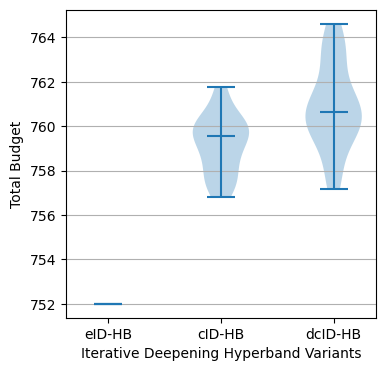

In [97]:
import matplotlib.pyplot as plt
import numpy as np

fig, ax = plt.subplots(nrows=1, figsize=(4, 4))

# generate some random test data
all_data = [eid_hb, pid_hb, did_hb]#, ih_hb]

# plot violin plot
ax.violinplot(all_data, showmeans=False, showmedians=True)

# adding horizontal grid lines
ax.yaxis.grid(True)
ax.set_xticks([y + 1 for y in range(len(all_data))],
                  labels=['eID-HB', 'cID-HB', 'dcID-HB'])#, 'IH-HB'])
ax.set_xlabel('Iterative Deepening Hyperband Variants')
ax.set_ylabel('Total Budget')
#plt.yscale('log')

plt.savefig('budget_distribution_yahpo_lcbench_3.pdf')
plt.show()